<a href="https://colab.research.google.com/github/mikael-pintassilgo/portfolio/blob/my-pages/_posts/colab-notebooks/AB_test_of_a_product_form_redesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B testing of a new product form design in an ERP system

In usability tests we conducted on new users of our ERP solution, we saw that there were many fields on the product form and users spent a lot of time trying to fill in all the fields, even those they might not need.

The product manager and UX designer decided to redesign the form.
To do this, we collected statistics on frequently used fields and rearranged the form so that frequently used fields were visible immediately when starting to work with the form, and other elements that are used less often were moved to other tabs of the form. The more often an element was filled in, the higher we placed it on the form.

To understand whether we had improved the design or not, we decided to conduct an A/B test, as the product form is one of the most important forms in the ERP solution, and we wanted to make sure we were on the right track.

We planned to test two versions of the product form design:
<ul>
<li>On the first form (as before), the goods were arranged in collapsed groups.</li>
<li>On the second form (new design), the product fields were located on tabs.</li>
</ul>

An abstract example is shown in the figure below:

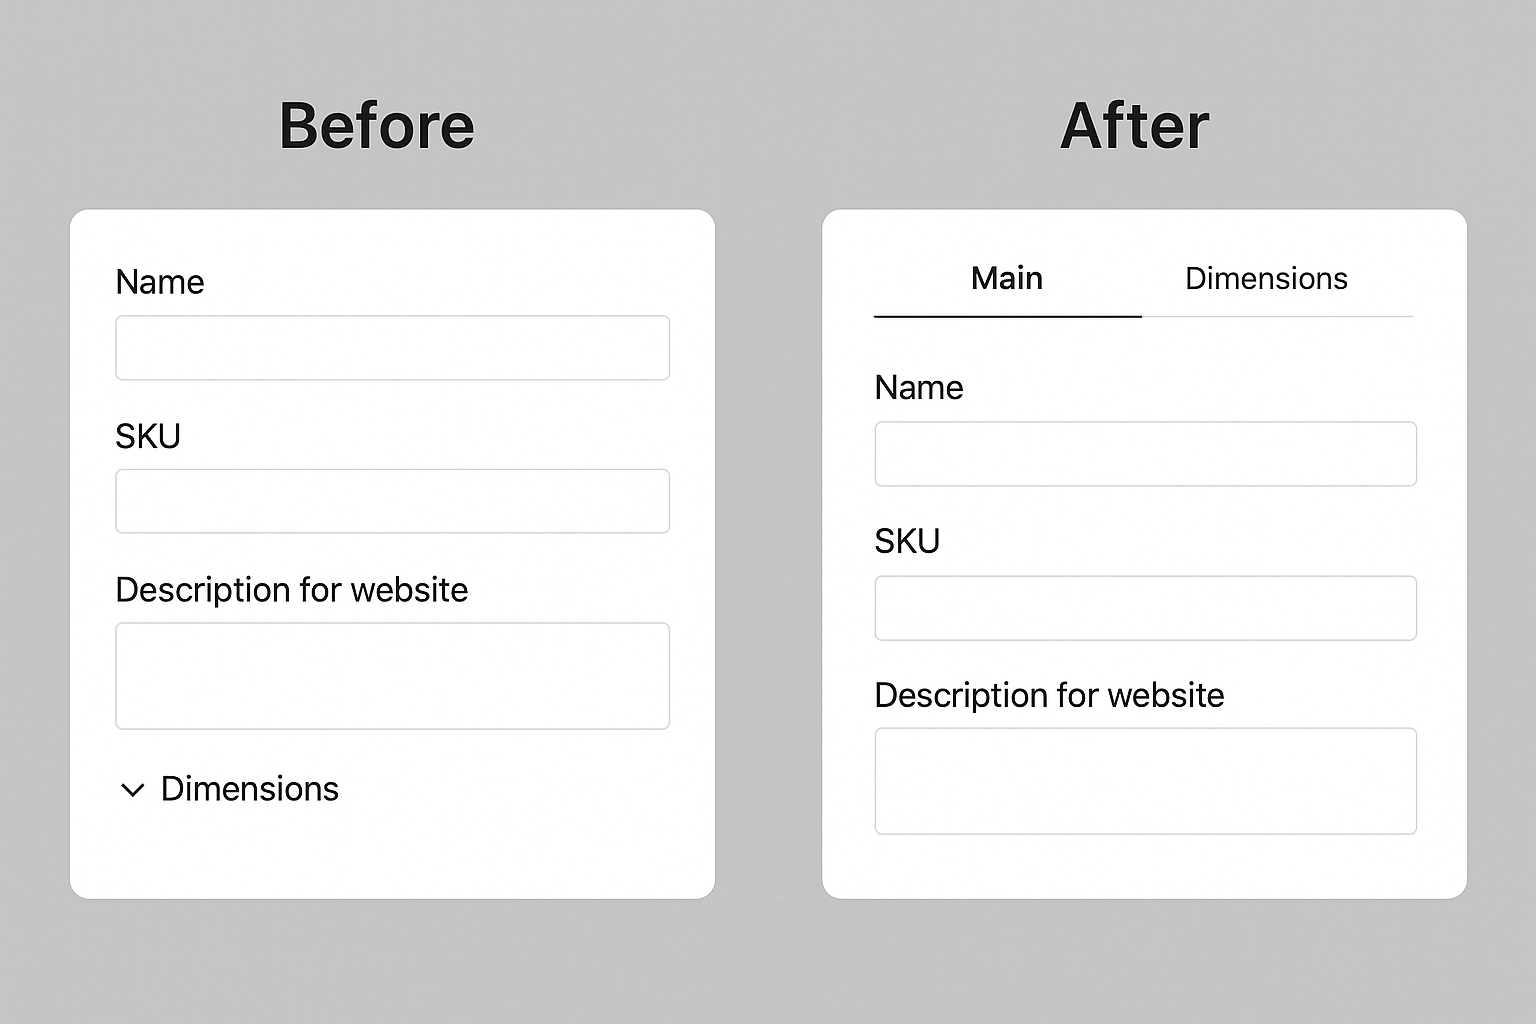

To conduct an A/B test, we need to choose a metric by which to evaluate our design. In our case, this was the median form completion time. This approach ensures that our final metric (the median) remains robust to situations where users complete the form very quickly or very slowly (outliers). We also ensured that other metrics, such as form abandonment rate and average number of form edit returns, did not degrade.
For simplicity, we will focus on testing the median time below.

So, to evaluate the results, we first needed to organize the collection of product form statistics.
We added this feature to the program. Since we had no data on form completion time, we decided to first collect data on the current design to estimate the average completion time and variance before conducting the A/B test. This data will help us calculate the sample size we need for the experiment.

To calculate the sample size, the following formula was used:

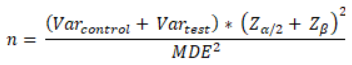

We substituted the data we obtained before the A/B test into this formula. In this case, the variances (Var in the formula) of the control and test samples are assumed to be equal to the variance obtained from historical data. For our example, let's assume that users spend an average of 120 seconds filling out our product form, with a standard deviation of 30 seconds. This means that users spend between 90 (120 - 30) and 150 (120 + 30) seconds filling out the form.

The letter Z in the formula is a standardised measure, and its values are known. But to replace these values with specific numbers, we need to know alpha and beta. We choose these numbers ourselves.

Alpha is a type I error, and beta is a type II error. In general, for A/B tests, it is customary to take alpha = 5% and beta = 20%. This is sufficient for our task. For these values of alpha and beta, it is known that Z(alpha/2), i.e. Z(0.025) = 1.96, and Z(0.2) = 0.842.

Now we need to figure out MDE. In simple terms, this is the minimum desired effect in absolute terms. In our case, we conducted several corridor usability tests with two interface options and expected to reduce the time it takes to fill out the product form by 15%. For MDE, we need to specify an absolute value, so 120 seconds * 15% = 18 seconds. That is, we expect to reduce the time it takes to fill out the form by 18 seconds with the new design. In practice, there are also situations where the amount of change can be tied to the cost of implementing and supporting the new feature.

So, let's substitute all the values into our formula:

n = (30^2 + 30^2) * (1.96 + 0.842)^2 / (-18)^2 = 44 users

The code for calculating the sample size is shown below:

In [49]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# --- Function for calculating the minimum sample size for two independent groups ---
def calculate_sample_size(sigma, delta, alpha=0.05, power=0.8):
  """
  sigma: standard deviation of the metric
  delta: expected change (absolute)
  alpha: significance level
  power: desired power (1 - beta)
  """
  Z_alpha = stats.norm.ppf(1 - alpha/2)
  Z_beta = stats.norm.ppf(power)
  n_per_group = 2 * ((Z_alpha + Z_beta) * sigma / delta)**2
  return int(np.ceil(n_per_group))

In [51]:
# Example: our key metric
sigma = 30 # standard deviation of time
delta = 120 * 0.15 # 15% improvement
alpha = 0.05
power = 0.8

required_n = calculate_sample_size(sigma, delta, alpha, power)
print(f"Minimum sample size per group: {required_n} users")

# --- Now we can plan the experiment ---
n_users = 500 # For greater reliability and additional metrics
print(f"Number of users: {n_users} (above minimum: {required_n})")

Minimum sample size per group: 44 users
Number of users: 500 (above minimum: 44)


44 users is the minimum we need to recruit in order to conduct the experiment with the specified parameters. But we can take more.


Since we will be analysing the median time in the A/B test, rather than the average, and based on references from other researchers' work, it was known that the data would most likely be skewed to the right, we need to use the asymptotic relative efficiency (ARE) of the U-test relative to the t-test to adjust the calculations. The ARE for a normal distribution is approximately 0.955.


$$n_{\text{M-W}} \approx \frac{n_{\text{t-test}}}{\text{ARE}} = \frac{n_{\text{t-test}}}{0.955}$$

As a result, dividing 44 by 0.955 gives us approximately 47 users per group. We decided to recruit 500 users, as we saw from the statistics that this was realistic to achieve in a week (7 days). This allowed us to increase the power of the experiment, i.e. reduce the probability of a type II error.

It is also necessary to take seasonality into account, for example, working days and weekends, or mornings and evenings. But in our case, we decided not to rely on seasonality, as it makes no difference to us what time of day or day of the week the product form was filled out.


It remained to be seen how we would recruit these 44 users and what kind of users we needed.
To reduce the variability of the experiment, we selected users who work on our online service via a thin client, with an effective screen resolution of 1920 x 1080 and a Windows operating system.


We proceeded as follows. When any ‘new’ user, i.e. one who did not yet have any products in the database, began to add their first new product to the database, we showed odd-numbered users the previous version of the design and even-numbered users the new version of the design throughout the experiment. This allowed us to analyse users who work with products. If a user completed the product registration, we included them in the sample.
Then we waited seven days and took the first 500 users in each group who had added at least seven products to calculate the median time taken to complete the product form. We did not take into account the time taken to add the first two products in order to reduce the learning effect.



Instead of using real data for the example, we will generate data artificially.
The code for generating such data is presented below:

In [52]:
# --- 1. Simulation parameters and fictitious data generation ---

# Sample size per group
N = 500

# Gamma distribution parameters for simulating truncated time (Mean = 120 sec)
K_SHAPE = 4
THETA_SCALE_CONTROL = 30 # Average = 4 * 30 = 120

# Expected effect (MDE): 15% reduction in median (120 * 0.15 = 18 seconds)
MDE_ABS = 18

# Simulation of the result: POSITIVE effect
# The median of the gamma distribution is not calculated simply as k*theta, so
# we simply shift the distribution in the test group.
# The new median of the test group should be LESS than that of the control group.
# We will aim for a shift so that the mean of the test group is 120 - 1.5 * 18 = 93 seconds.
THETA_SCALE_TEST = (120 - MDE_ABS * 1.5) / K_SHAPE

# Data generation
control_data = stats.gamma.rvs(a=K_SHAPE, scale=THETA_SCALE_CONTROL, size=N)
test_data = stats.gamma.rvs(a=K_SHAPE, scale=THETA_SCALE_TEST, size=N)

# Let's make sure that time is not negative.
control_data = np.maximum(control_data, 1)
test_data = np.maximum(test_data, 1)

# Creating a DataFrame for analysis and visualisation
df_control = pd.DataFrame({'time_to_fill': control_data, 'group': 'A (Control)'})
df_test = pd.DataFrame({'time_to_fill': test_data, 'group': 'B (Test)'})
df_combined = pd.concat([df_control, df_test])

Additionally, before launching the A/B test, we conducted an A/A test to ensure that everything was functioning correctly. This test is similar to an A/B test, but instead of different design versions, the same old design version is shown to two groups of users.

Let's return to our A/B test.
We have collected the necessary data and now we need to perform the calculations.
To do this, we need to select a statistical test that will reveal the statistical significance of the results obtained.
The main characteristics that determine the choice of statistical test are the metric, sample size, and distribution type.
Median time is a quantitative metric.
Our data is distributed with a right skew, apparently because some users take a long time to fill out forms, for example, because they get distracted.
Our sample size is quite large.

Information about the distribution can be seen in the following graphs:

In [53]:
# --- 2. Calculation and evaluation of results (Median) ---

# Let's calculate the key metrics
median_control = np.median(control_data)
median_test = np.median(test_data)
diff_median = median_control - median_test

print("--- Assessment of results by median ---")
print(f"\nMedian of Group A (Control): {median_control:.2f} seconds")
print(f"Median of Group B (Test): {median_test:.2f} seconds")
print(f"\nAbsolute decrease in median: {diff_median:.2f} seconds")
print(f"Percentage decrease in median: {(diff_median / median_control) * 100:.2f} %")
print(f"\nMinimum expected effect (MDE): {MDE_ABS} seconds")

--- Assessment of results by median ---

Median of Group A (Control): 114.81 seconds
Median of Group B (Test): 81.20 seconds

Absolute decrease in median: 33.60 seconds
Percentage decrease in median: 29.27 %

Minimum expected effect (MDE): 18 seconds


/tmp/ipython-input-3182503767.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


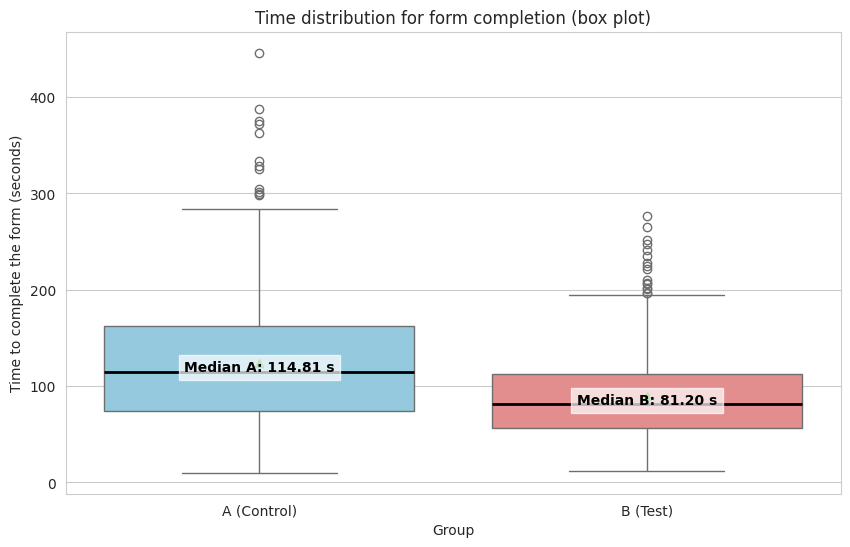

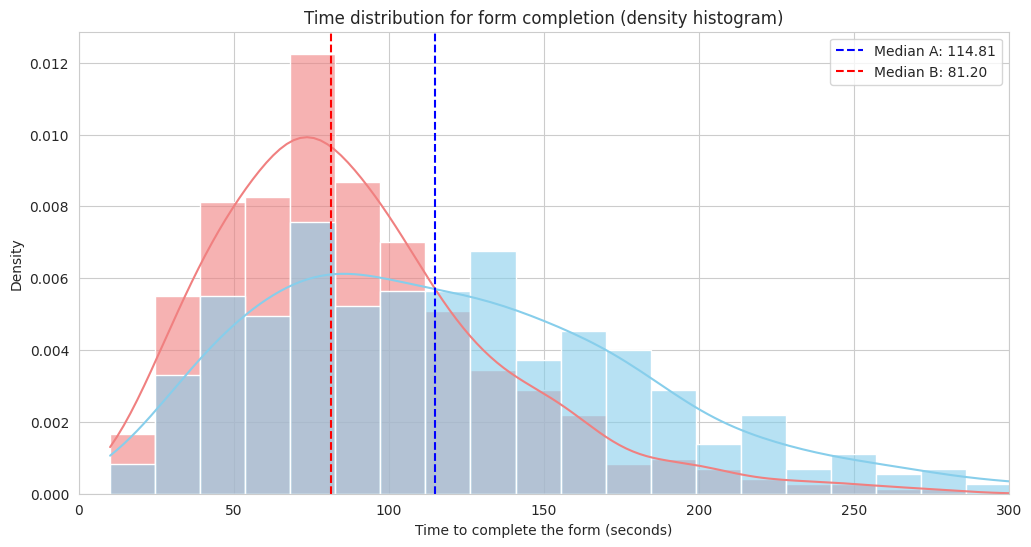

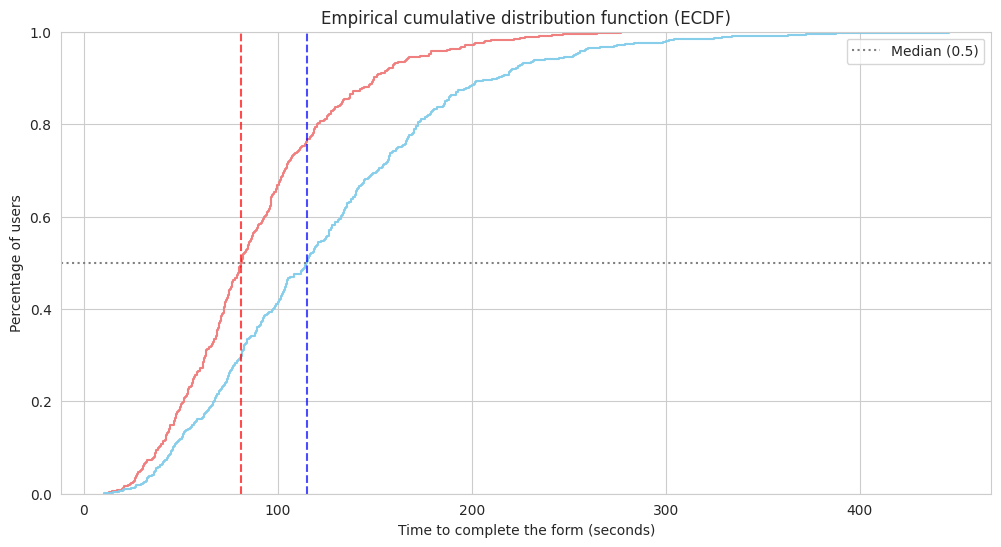

In [54]:
# --- 3. Visualisation with a focus on Mediana ---

# Let's set the seaborn style
sns.set_style("whitegrid")

# 3.1 Boxplots are well suited for analysing the median.

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_combined,
    x='group',
    y='time_to_fill',
    palette={'A (Control)': 'skyblue', 'B (Test)': 'lightcoral'},
    showmeans=True, # Optional: show average
    medianprops={'color': 'black', 'linewidth': 2} # Visual highlighting of the median
)
plt.title('Time distribution for form completion (box plot)')
plt.xlabel('Group')
plt.ylabel('Time to complete the form (seconds)')
plt.text(0, median_control, f'Median A: {median_control:.2f} s', horizontalalignment='center', color='black', weight='bold', bbox=dict(facecolor='white', alpha=0.7))
plt.text(1, median_test, f'Median B: {median_test:.2f} s', horizontalalignment='center', color='black', weight='bold', bbox=dict(facecolor='white', alpha=0.7))
plt.show()

print()

# 3.2 Histograms with median

plt.figure(figsize=(12, 6))
sns.histplot(data=df_combined, x='time_to_fill', hue='group', kde=True, stat='density', common_norm=False, alpha=0.6, palette={'A (Control)': 'skyblue', 'B (Test)': 'lightcoral'},)
plt.title('Time distribution for form completion (density histogram)')
plt.xlabel('Time to complete the form (seconds)')
plt.ylabel('Density')

# Adding vertical lines for the medians
plt.axvline(median_control, color='blue', linestyle='--', label=f'Median A: {median_control:.2f}')
plt.axvline(median_test, color='red', linestyle='--', label=f'Median B: {median_test:.2f}')
plt.legend()
plt.xlim(0, 300) # Limiting the X-axis for better readability of skewed data
plt.show()

print()

# 3.3 ECDF - to compare distributions

plt.figure(figsize=(12, 6))
sns.ecdfplot(data=df_combined, x='time_to_fill', hue='group', palette={'A (Control)': 'skyblue', 'B (Test)': 'lightcoral'},)
plt.title('Empirical cumulative distribution function (ECDF)')
plt.xlabel('Time to complete the form (seconds)')
plt.ylabel('Percentage of users')

# Add a horizontal line for the median (0.5 user share)
plt.axhline(0.5, color='gray', linestyle=':', label='Median (0.5)')

# Add vertical lines where the ECDF crosses 0.5
plt.axvline(median_control, color='blue', linestyle='--', alpha=0.7)
plt.axvline(median_test, color='red', linestyle='--', alpha=0.7)

plt.legend()
plt.show()

In this case, we can choose, for example, the non-parametric
<br>
<b>Mann-Whitney U Test</b>.


Statistical tests are used to test hypotheses.

Our hypotheses are as follows:
<ul>
<li><b>Null hypothesis (H0)</b>: The distribution of time spent completing the form in Group A (old design) and Group B (new design) is identical.
<li>
<b>Alternative hypothesis (H1)</b>: The distribution of form completion time in Group B is less than in Group A.

We will use a one-tailed test, as we need to check that the time is decreasing.


In [55]:
print("\n--- Statistical test: Mann-Whitney U Test ---")

# Mann-Whitney U Test
# H0: The distributions are identical.
# H1: The distribution of test_data is stochastically LESS than control_data (less time).
# alternative=“less” checks that the first distribution (test) is less than the second (control).
u_stat, p_value = stats.mannwhitneyu(
    x=test_data,
    y=control_data,
    alternative='less',
    use_continuity=False
)

# Level of significance
alpha = 0.05

print(f"\nU-statistics: {u_stat:.2f}")
print(f"P-value (one-sided): {p_value:.5f}")

print()

# Conclusion
if p_value < alpha:
    print(f"✅ Conclusion: P-value < {alpha}. We reject H0. The difference in medians is statistically significant (Improvement).")
else:
    print(f"❌ Conclusion: P-value > {alpha}. We do not reject H0. There is no statistically significant difference.")



--- Statistical test: Mann-Whitney U Test ---

U-statistics: 85477.00
P-value (one-sided): 0.00000

✅ Conclusion: P-value < 0.05. We reject H0. The difference in medians is statistically significant (Improvement).


## Conclusions

<b>Result</b>: The test showed a <b>statistically significant decrease</b> in the median time taken to complete the form in Group B (new design) compared to Group A (control).

<b>Recommendation</b>: <b>Adopt the new design</b> of the form (Group B). Plan to roll out the new functionality to all users and ensure that there is no negative impact on other metrics (e.g., data completeness).

## Additionally: Confidence interval

Visualising the confidence interval (CI) is the best way to understand where the true difference between the medians (or means) of groups A and B is likely to lie.

For the Mann-Whitney U test, direct calculation of the confidence interval for the difference in medians requires the use of the bootstrap method. Bootstrap is a method of repeatedly resampling data from your sample with replacement, which allows you to construct the distribution of the statistic you are interested in (in this case, the difference between the medians) and estimate its confidence interval.

In [56]:
# --- 2. Function for bootstrap ---
def bootstrap_median_diff(control, test, num_reps=1000, alpha=0.05):
    """
    Calculates the confidence interval for the difference between medians using bootstrapping.

    control, test: data arrays of two groups.
    num_reps: number of bootstrap iterations.
    alpha: significance level (for 95% CI alpha=0.05).
    """
    median_diffs = []

    for _ in range(num_reps):
        # 1. Sampling with replacement
        # Bootstrap samples are the same size as the original data
        control_sample = np.random.choice(control, size=len(control), replace=True)
        test_sample = np.random.choice(test, size=len(test), replace=True)

        # 2. Statistical calculation (Median difference: Control - Test)
        # A positive difference means that Test < Control (i.e., improvement)
        diff = np.median(control_sample) - np.median(test_sample)
        median_diffs.append(diff)

    # 3. Confidence interval calculation (percentile method)
    # Lower percentile: alpha/2; Upper percentile: 1 - alpha/2
    lower_bound = np.percentile(median_diffs, 100 * (alpha / 2))
    upper_bound = np.percentile(median_diffs, 100 * (1 - alpha / 2))

    return np.array(median_diffs), lower_bound, upper_bound

Starting bootstrap (5000 iterations)...

--- Bootstrap results ---

Observed median difference (Control - Test): 33.60 sec
Median of the distribution of differences: 33.52 sec
95% Confidence Interval (CI): [22.67, 41.47] sec



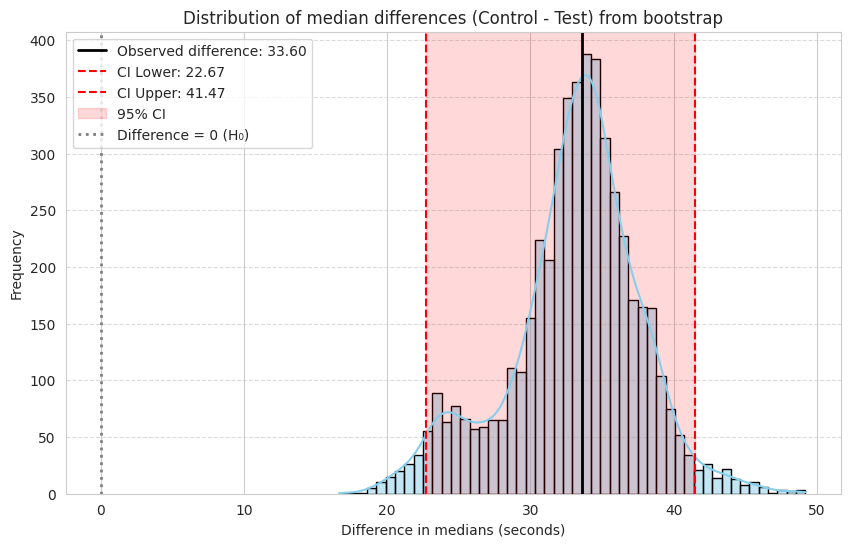


--- Interpretation of the Confidence Interval ---

✅ The confidence interval lies entirely in the positive region.
This means that we are 95% confident that the new design reduces the time it takes to fill out the form.


In [57]:
# --- 3. Bootstrap execution ---
NUM_BOOTSTRAP_REPS = 5000 # Let's increase the number of repetitions for greater accuracy.
ALPHA = 0.05 # 95% Confidence interval

print(f"Starting bootstrap ({NUM_BOOTSTRAP_REPS} iterations)...")
diff_distribution, ci_lower, ci_upper = bootstrap_median_diff(
    control_data,
    test_data,
    num_reps=NUM_BOOTSTRAP_REPS,
    alpha=ALPHA
)

# Calculation of the observed difference and median of the distribution
observed_diff = np.median(control_data) - np.median(test_data)
median_of_diffs = np.median(diff_distribution)

# --- 4. Conclusion of results ---
print("\n--- Bootstrap results ---")
print(f'\nObserved median difference (Control - Test): {observed_diff:.2f} sec')
print(f'Median of the distribution of differences: {median_of_diffs:.2f} sec')
print(f'95% Confidence Interval (CI): [{ci_lower:.2f}, {ci_upper:.2f}] sec')

print()

# --- 5. Visualisation of Confidence Interval ---

plt.figure(figsize=(10, 6))
# Histogram of the distribution of median differences
sns.histplot(diff_distribution, kde=True, bins=50, color='skyblue', edgecolor='black')

plt.title('Distribution of median differences (Control - Test) from bootstrap')
plt.xlabel('Difference in medians (seconds)')
plt.ylabel('Frequency')

# Line for observed difference
plt.axvline(observed_diff, color='black', linestyle='-', linewidth=2, label=f'Observed difference: {observed_diff:.2f}')

# 95% Confidence Interval
plt.axvline(ci_lower, color='red', linestyle='--', linewidth=1.5, label=f'CI Lower: {ci_lower:.2f}')
plt.axvline(ci_upper, color='red', linestyle='--', linewidth=1.5, label=f'CI Upper: {ci_upper:.2f}')
plt.axvspan(ci_lower, ci_upper, alpha=0.15, color='red', label='95% CI')

# Line indicating no effect (Difference = 0)
plt.axvline(0, color='gray', linestyle=':', linewidth=2, label='Difference = 0 (H₀)')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 6. Interpretation CI ---
print("\n--- Interpretation of the Confidence Interval ---")
if ci_lower > 0:
    print("\n✅ The confidence interval lies entirely in the positive region.")
    print("This means that we are 95% confident that the new design reduces the time it takes to fill out the form.")
elif ci_upper < 0:
    print("\n❌ The confidence interval lies entirely in the negative region.")
    print("This means that we are 95% sure that the new design INCREASES the time it takes to fill out the form.")
else:
    print("\n⚠️ The confidence interval includes zero.")
    print("This means that we cannot rule out that the true difference in medians is zero, and the effect is NOT statistically significant.")

The confidence interval does not include zero, meaning the result is statistically significant. Since we are measuring $(\text{Median }_{\text{Control}} - \text{Median }_{\text{Test}})$, positive difference values ​​mean improvement (Test is faster than Control).